<a href="https://colab.research.google.com/github/Jovania/Projetos-01/blob/master/Jovania_MLcovid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-RS

O objetivo desta tarefa é utilizar e avaliar técnicas de aprendizado de máquina em uma base de dados real. Esta base é originada da Secretaria Estadual de Saúde do RS e contém todos casos registrados de COVID-19 no estado, com informações diversas sobre cada caso, incluindo informações de hospitalização e óbito. 

Este notebook contém o esqueleto básico para carregar os dados e deve ser expandido para explorar metodologias diversas.

# Carregamento dos dados

In [1]:
# Baixar os dados da Secretaria de Saude e renomear para algo mais usável 
# Observar que os dados são atualizados diariamente, pode ser uma boa ideia fazer uma copia mais estável

!wget https://ti.saude.rs.gov.br/covid19/download
!mv download dados_covid_rs.csv

--2020-11-07 00:37:32--  https://ti.saude.rs.gov.br/covid19/download
Resolving ti.saude.rs.gov.br (ti.saude.rs.gov.br)... 200.198.173.170
Connecting to ti.saude.rs.gov.br (ti.saude.rs.gov.br)|200.198.173.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘download’

download                [       <=>          ]  51.75M  3.37MB/s    in 18s     

2020-11-07 00:37:53 (2.91 MB/s) - ‘download’ saved [54269374]



In [2]:
# Vamos usar o pandas para carregar os dados. Observar que o separador de colunas no arquivo é ponto-e-vírgula.

import pandas as pd
dados = pd.read_csv("dados_covid_rs.csv", delimiter=';')
dados.head()

,COD_IBGE,MUNICIPIO,COD_REGIAO_COVID,REGIAO_COVID,SEXO,FAIXAETARIA,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_EVOLUCAO,EVOLUCAO,HOSPITALIZADO,FEBRE,TOSSE,GARGANTA,DISPNEIA,OUTROS,CONDICOES,GESTANTE,DATA_INCLUSAO_OBITO,DATA_EVOLUCAO_ESTIMADA,RACA_COR,ETNIA_INDIGENA,PROFISSIONAL_SAUDE,BAIRRO,HOSPITALIZACAO_SRAG,FONTE_INFORMACAO,PAIS_NASCIMENTO,PES_PRIV_LIBERDADE
0,430003,ACEGUÁ,16,BAGE - R22,Feminino,20 a 29,RT-PCR,11/09/2020,08/09/2020,NaN,RECUPERADO,NAO,SIM,NAO,SIM,NAO,NAO,Gestante,SIM,NaN,22/09/2020,NAO INFORMADO,NAO ENCONTRADO,NAO INFORMADO,NaN,NAO,E-SUS,BRASIL,NAO
1,430003,ACEGUÁ,16,BAGE - R22,Masculino,15 a 19,RT-PCR,06/10/2020,06/10/2020,NaN,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,NaN,NAO,NaN,20/10/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
2,430003,ACEGUÁ,16,BAGE - R22,Feminino,40 a 49,RT-PCR,05/10/2020,29/09/2020,NaN,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,NaN,NAO,NaN,13/10/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
3,430003,ACEGUÁ,16,BAGE - R22,Feminino,50 a 59,TESTE RÁPIDO,19/10/2020,05/10/2020,NaN,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,NaN,NAO,NaN,19/10/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
4,430005,ÁGUA SANTA,14,PASSO FUNDO - R17 R18 R19,Masculino,70 a 79,TESTE RÁPIDO,03/11/2020,28/10/2020,NaN,EM ACOMPANHAMENTO,NAO,NAO,NAO,NAO,NAO,SIM,Doenças cardíacas crônicas,NAO,NaN,NaN,BRANCA,NaN,NAO,INTERIOR,NAO,E-SUS,NaN,NAO


In [3]:
# Qual o tamanho da tabela (linhas, colunas)?
dados.shape

(257785, 29)

# Pré-processamento

Os dados raramente vem limpos e prontos para uso. No mínimo, precisamos converter ou adequar tipos e lidar com valores faltantes. Também podemos querer expandir os dados, incluindo novas colunas derivadas dos próprios dados ou de fontes externas.

Por exemplo, temos várias colunas que são datas, mas estão representadas como strings. É uma boa ideia converter estas strings para datas reais

In [4]:
dados["DATA_CONFIRMACAO"] = pd.to_datetime(dados["DATA_CONFIRMACAO"], format="%d/%m/%Y")
dados["DATA_SINTOMAS"] = pd.to_datetime(dados["DATA_SINTOMAS"], format="%d/%m/%Y")
dados["DATA_EVOLUCAO"] = pd.to_datetime(dados["DATA_EVOLUCAO"], format="%d/%m/%Y")
dados["DATA_INCLUSAO_OBITO"] = pd.to_datetime(dados["DATA_INCLUSAO_OBITO"], format="%d/%m/%Y")
dados["DATA_EVOLUCAO_ESTIMADA"] = pd.to_datetime(dados["DATA_EVOLUCAO_ESTIMADA"], format="%d/%m/%Y")

dados.head()

,COD_IBGE,MUNICIPIO,COD_REGIAO_COVID,REGIAO_COVID,SEXO,FAIXAETARIA,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_EVOLUCAO,EVOLUCAO,HOSPITALIZADO,FEBRE,TOSSE,GARGANTA,DISPNEIA,OUTROS,CONDICOES,GESTANTE,DATA_INCLUSAO_OBITO,DATA_EVOLUCAO_ESTIMADA,RACA_COR,ETNIA_INDIGENA,PROFISSIONAL_SAUDE,BAIRRO,HOSPITALIZACAO_SRAG,FONTE_INFORMACAO,PAIS_NASCIMENTO,PES_PRIV_LIBERDADE
0,430003,ACEGUÁ,16,BAGE - R22,Feminino,20 a 29,RT-PCR,2020-09-11,2020-09-08,NaT,RECUPERADO,NAO,SIM,NAO,SIM,NAO,NAO,Gestante,SIM,NaT,2020-09-22,NAO INFORMADO,NAO ENCONTRADO,NAO INFORMADO,NaN,NAO,E-SUS,BRASIL,NAO
1,430003,ACEGUÁ,16,BAGE - R22,Masculino,15 a 19,RT-PCR,2020-10-06,2020-10-06,NaT,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,NaN,NAO,NaT,2020-10-20,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
2,430003,ACEGUÁ,16,BAGE - R22,Feminino,40 a 49,RT-PCR,2020-10-05,2020-09-29,NaT,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,NaN,NAO,NaT,2020-10-13,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
3,430003,ACEGUÁ,16,BAGE - R22,Feminino,50 a 59,TESTE RÁPIDO,2020-10-19,2020-10-05,NaT,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,NaN,NAO,NaT,2020-10-19,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
4,430005,ÁGUA SANTA,14,PASSO FUNDO - R17 R18 R19,Masculino,70 a 79,TESTE RÁPIDO,2020-11-03,2020-10-28,NaT,EM ACOMPANHAMENTO,NAO,NAO,NAO,NAO,NAO,SIM,Doenças cardíacas crônicas,NAO,NaT,NaT,BRANCA,NaN,NAO,INTERIOR,NAO,E-SUS,NaN,NAO


Algumas colunas possuem vários "NaN" (Not a Number) ou "NaT" (Not a Time), 

1.   Item da lista
2.   Item da lista

indicando que são valores faltantes.

Há diversas maneiras de lidar com buracos nos dados, vamos primeiro quantificar o problema contando o número de buracos por coluna.


In [5]:
rows = []
for column in dados.columns:
  row = {'coluna': column, 'nans': dados[column].isnull().sum(), 'frac_nans': dados[column].isnull().sum() / dados.shape[0]}
  rows.append(row)
res = pd.DataFrame(rows)
res[res.nans>0].sort_values('nans', ascending=False)

,coluna,nans,frac_nans
19,DATA_INCLUSAO_OBITO,251812,0.976830
9,DATA_EVOLUCAO,238765,0.926218
17,CONDICOES,217368,0.843214
20,DATA_EVOLUCAO_ESTIMADA,29058,0.112722
27,PAIS_NASCIMENTO,13358,0.051818
22,ETNIA_INDIGENA,13004,0.050445
24,BAIRRO,4975,0.019299
15,DISPNEIA,3037,0.011781
12,FEBRE,20,0.000078
13,TOSSE,20,0.000078


De potencial interesse temos a coluna `DATA_INCLUSAO_OBITO`.

Vemos que o numero de valores existentes é de cerca de 5 mil, o que coincide o numero de óbitos totais no RS. Assim, uma suposição razoável (que precisaria ser VALIDADA) é que um dado faltante indica que não houve óbito para aquele indivíduo. Vamos criar uma nova coluna `OBITO` indicando isso


In [6]:
# O método apply aplica uma função a cada linha do objeto
# Ao invés de definirmos uma função externa, usamos a funcionalidade "lambda" que permite criar uma função local
# Assim, na nova coluna teremos SIM se houver uma data e NAO se o valor for nulo

dados["OBITO"] = dados["DATA_INCLUSAO_OBITO"].apply(lambda x: "NAO" if pd.isnull(x) else "SIM")

Vamos tratar outra coluna. `DISPNEIA` possui 1% dos valores faltando. Poderíamos preencher os valores faltantes com SIM ou NAO aleatoriamente, seguindo a distribuição do resto dos dados. Outra alternativa é atribuir um novo valor, como "FALTANDO", pois a falta deste valor pode ser um indicador. Vamos com esta última, utilizando a função `fillna` do pandas, que preenche valores faltantes com algum valor


In [7]:
dados["DISPNEIA"] = dados["DISPNEIA"].fillna(0)

Para FEBRE, vamos adotar a outra alternativa e preencher os dados faltantes com valores aleatorios, mas que seguem a distribuição dos dados. Note: nem idéia se isso é uma suposição razoável e você vai querer pensar sobre isso antes de adotar a solução.


In [8]:
import numpy as np

dist = dados["FEBRE"].value_counts(normalize=True)
faltantes = dados['FEBRE'].isnull()
dados.loc[faltantes,'FEBRE'] = np.random.choice(dist.index, size=len(dados[faltantes]), p=dist.values)

# Testando para ver se não há mais valores faltantes
dados["FEBRE"].isnull().any()

False

Neste ponto devemos continuar tratando as colunas com dados faltantes. A exceção é se não usaremos estas colunas nas etapas posteriores. Ainda que em alguns casos ter valores faltantes não é um problema, acaba-se por jogar a responsabilidade de como lidar com isso para módulos e bibliotecas, o que reduz a transparência do modelo resultante. Sempre que possível, é ideal lidar com dados faltantes antes das demais etapas.

# Padronização dos **dados**

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
# função que padroniza os nomes das condições
def padroniza_itens(lista):
   # para cada condição da lista de condições do paciente
   for i in range(len(lista)):
      # remove caracteres em branco do início ou final da string
      lista[i] = lista[i].strip()
      # verifica se a condição apresenta falta de um caractere em sua última palavra
      # e, caso positivo, realiza a devida correção/substituição
      if lista[i].endswith("Asm"): lista[i] = lista[i].replace("Asm", "Asma")
      if lista[i].endswith("mellitu"): lista[i] = lista[i].replace("mellitu", "mellitus")
      if lista[i].endswith("Crônic"): lista[i] = lista[i].replace("Crônic", "Crônica")
      if lista[i].endswith("Imunodeficiênci"): lista[i] = lista[i].replace("Imunodeficiênci", "Imunodeficiência")
      if lista[i].endswith("Obesidad"): lista[i] = lista[i].replace("Obesidad", "Obesidade")
      if lista[i].endswith("Outro"): lista[i] = lista[i].replace("Outro", "Outros")
   # retorna a lista padronizada
   return lista




**Binarização das categorias**


In [10]:
def binariza_multi_categoricos(dataset):
   # Remove a vírgula do nome de uma das possíveis condições dos pacientes e, após, transforma as strings de condições
   # em listas, separando cada condição da string com o auxílio da função split, considerando a vírgula como separador.
   dataset['CONDICOES'] = dataset['CONDICOES'].apply(lambda x: (str(x).replace("(graus 3, 4 ou 5)", "(graus 3 4 ou 5)").split(",")))

   # padroniza a nomenclatura das condições, através da função 'padroniza_itens',
   # para evitar múltiplos atributos relacionados a uma mesma condição
   dataset['CONDICOES'] = dataset['CONDICOES'].apply(lambda x: padroniza_itens(x))

   # Com as listas de condições ajustadas, aplica o MultiLabelBinarizer
   cod = MultiLabelBinarizer()
   cod.fit(dataset['CONDICOES'])
   atributo_transformado = cod.transform(dataset['CONDICOES'])
   onehot = pd.DataFrame(atributo_transformado)
   onehot.columns = pd.Series(cod.classes_).apply(lambda x: 'CONDICOES' + '_' + x)
   dataset = pd.concat([dataset, onehot], axis=1).drop(['CONDICOES'], axis=1)
   return dataset

dados = binariza_multi_categoricos(dados)

In [11]:
def binariza_sintomas(dataset):

# Binarizando as colunas

      dataset['HOSPITALIZADO']=dataset['HOSPITALIZADO'].replace('SIM',1)
      dataset['HOSPITALIZADO']=dataset['HOSPITALIZADO'].replace('NAO',0)
      dataset['HOSPITALIZADO']=dataset['HOSPITALIZADO'].replace(np.nan,0)

      dataset['FEBRE']=dataset['FEBRE'].replace('SIM',1)
      dataset['FEBRE']=dataset['FEBRE'].replace('NAO',0)
      dataset['FEBRE']=dataset['FEBRE'].replace(np.nan,0)

      dataset['TOSSE']=dataset['TOSSE'].replace('SIM',1)
      dataset['TOSSE']=dataset['TOSSE'].replace('NAO',0)
      dataset['TOSSE']=dataset['TOSSE'].replace(np.nan,0)

      dataset['GARGANTA']=dataset['GARGANTA'].replace('SIM',1)
      dataset['GARGANTA']=dataset['GARGANTA'].replace('NAO',0)
      dataset['GARGANTA']=dataset['GARGANTA'].replace(np.nan,0)

      dataset['DISPNEIA']=dataset['DISPNEIA'].replace('SIM',1)
      dataset['DISPNEIA']=dataset['DISPNEIA'].replace('NAO',0)
      dataset['DISPNEIA']=dataset['DISPNEIA'].replace(np.nan,0)

      dataset['OUTROS']=dataset['OUTROS'].replace('SIM',1)
      dataset['OUTROS']=dataset['OUTROS'].replace('NAO',0)
      dataset['OUTROS']=dataset['OUTROS'].replace(np.nan,0)

      dataset['GESTANTE']=dataset['GESTANTE'].replace('SIM',1)
      dataset['GESTANTE']=dataset['GESTANTE'].replace('NAO',0)
      dataset['GESTANTE']=dataset['GESTANTE'].replace(np.nan,0)

      dataset['EVOLUCAO']=dataset['EVOLUCAO'].replace('OBITO',1)
      dataset['EVOLUCAO']=dataset['EVOLUCAO'].replace('RECUPERADO',0)
      dataset['EVOLUCAO']=dataset['EVOLUCAO'].replace('OBITO OUTRAS CAUSAS',2)
      dataset['EVOLUCAO']=dataset['EVOLUCAO'].replace('EM ACOMPANHAMENTO',3)
      dataset['EVOLUCAO']=dataset['EVOLUCAO'].replace(np.nan,0)
     
      dataset['OBITO']=dataset['OBITO'].replace('SIM',1)
      dataset['OBITO']=dataset['OBITO'].replace('NAO',0)
      dataset['OBITO']=dataset['OBITO'].replace(np.nan,0)
       
      dataset['CRITERIO']=dataset['CRITERIO'].replace('RT-PCR',1)
      dataset['CRITERIO']=dataset['CRITERIO'].replace('TESTE RÁPIDO',0)
      dataset['CRITERIO']=dataset['CRITERIO'].replace(np.nan,0)


      return dataset  
dados_colunas_bin = binariza_sintomas(dados)

**Excluindo as colunas desnecessarias e gerando um novo dataframe com as colunas que interessam**

In [12]:
def deleta_col(dataset):

     dataframenovo = dataset.drop(['COD_IBGE'], axis='columns')
     dataframenovo = dataframenovo.drop(['MUNICIPIO'], axis='columns')
     dataframenovo = dataframenovo.drop(['COD_REGIAO_COVID'], axis='columns')
     dataframenovo = dataframenovo.drop(['REGIAO_COVID'], axis='columns')
     dataframenovo = dataframenovo.drop(['SEXO'], axis='columns')
     dataframenovo = dataframenovo.drop(['FAIXAETARIA'], axis='columns')
     dataframenovo = dataframenovo.drop(['DATA_CONFIRMACAO'], axis='columns')
     dataframenovo = dataframenovo.drop(['DATA_SINTOMAS'], axis='columns')
     dataframenovo = dataframenovo.drop(['DATA_INCLUSAO_OBITO'], axis='columns')
     dataframenovo = dataframenovo.drop(['DATA_EVOLUCAO'], axis='columns')
     dataframenovo = dataframenovo.drop(['DATA_EVOLUCAO_ESTIMADA'], axis='columns')
     dataframenovo = dataframenovo.drop(['RACA_COR'], axis='columns')
     dataframenovo = dataframenovo.drop(['ETNIA_INDIGENA'], axis='columns')
     dataframenovo = dataframenovo.drop(['PROFISSIONAL_SAUDE'], axis='columns')
     dataframenovo = dataframenovo.drop(['BAIRRO'], axis='columns')
     dataframenovo = dataframenovo.drop(['HOSPITALIZACAO_SRAG'], axis='columns')
     dataframenovo = dataframenovo.drop(['FONTE_INFORMACAO'], axis='columns')
     dataframenovo = dataframenovo.drop(['PAIS_NASCIMENTO'], axis='columns')
     dataframenovo = dataframenovo.drop(['PES_PRIV_LIBERDADE'], axis='columns')
     dataframenovo = dataframenovo.drop(['CRITERIO'], axis='columns')
     dataframenovo = dataframenovo.drop(['OBITO'], axis='columns')
     dataframenovo = dataframenovo.drop(['EVOLUCAO'], axis='columns')
   
     return dataframenovo
dados_importantes = deleta_col(dados_colunas_bin)

In [14]:
dados_importantes


,HOSPITALIZADO,FEBRE,TOSSE,GARGANTA,DISPNEIA,OUTROS,GESTANTE,CONDICOES_Asma,CONDICOES_Diabetes,CONDICOES_Diabetes mellitus,CONDICOES_Doença Cardiovascular Crônica,CONDICOES_Doença Hematológica Crônica,CONDICOES_Doença Hepática Crônica,CONDICOES_Doença Neurológica Crônica,CONDICOES_Doença Renal Crônica,CONDICOES_Doenças cardíacas crônicas,CONDICOES_Doenças renais crônicas em estágio avançado (graus 3 4 ou 5),CONDICOES_Doenças respiratórias crônicas descompensadas,CONDICOES_Gestante,CONDICOES_Gestante de alto risco,CONDICOES_Imunodeficiência,CONDICOES_Imunossupressão,CONDICOES_Obesidade,CONDICOES_Outra Pneumatopatia Crônica,CONDICOES_Outros,CONDICOES_Pneumatopatia Crônica,CONDICOES_Portador de doenças cromossômicas ou estado de fragilidade imunológica,CONDICOES_Puérpera,CONDICOES_Puérpera (até 45 dias do parto),CONDICOES_Síndrome de Down,CONDICOES_nan
0,0,1,0.0,1.0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.0,0.0,0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257780,0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
257781,1,1,0.0,0.0,0,0.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
257782,1,0,0.0,0.0,1,0.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
257783,1,0,1.0,1.0,0,0.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**A coluna óbito é a mais importante**

In [13]:
dados_target = dados_colunas_bin ['OBITO'] 

In [15]:
dados_target

0         0
1         0
2         0
3         0
4         0
         ..
257780    0
257781    0
257782    0
257783    1
257784    0
Name: OBITO, Length: 257785, dtype: int64

# **Treinamento**
Treinar com o modelo arvore de decisão como modelo "DecisionTreeClassifier".
O sklearn implementa o DecisionTreeClassifier, que é um modelo CART. Podemos aproximar o modelo do C4.5 usando entropia no lugar de gini para decidir os atributos em cada nó. De qualquer forma, este modelo lida automaticamente com atributos numéricos e implementa poda.

In [17]:
from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier(random_state=0, criterion="entropy")

# A função fit recebe como primeiro parâmetro uma matriz CxN, com C colunas e N linhas, onde cada linha especifica um exemplo
# O segundo parâmetro é um vetor com N posições, indicando os rótulos das linhas da matriz no primeiro parâmetro

X_treino = dados_importantes
y_treino = dados_target
modelo_treinado = modelo.fit(X_treino, y_treino)


# **Avaliação do modelo**
Com o modelo treinado, temos que avaliá-lo no conjunto de teste. O sklearn implementa a maior parte das métricas comuns, bem como permite mostrar a matriz de confusão completa.

In [18]:
from sklearn.metrics import accuracy_score

# Separamos atributos e classe dos dados de teste
X_teste = dados_importantes
y_teste = dados_target

# Passamos os exemplos sem classe pelo modelo treinado, que retorna a predicao em um vetor
predicoes = modelo_treinado.predict(X_teste)

# Com as predicoes, podemos calcular as métricas. Abaixo, a acurácia.
# Observe que sempre passamos os valores verdadeiros (y_teste) e depois as predicoes
acuracia = accuracy_score(y_teste, predicoes)
print("Acurácia do modelo: ", acuracia)

Acurácia do modelo:  0.9827996198382373


**Relatório com as principais métricas**

In [19]:

from sklearn.metrics import classification_report

relatorio = classification_report(y_teste, predicoes)
print(relatorio)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    251812
           1       0.76      0.38      0.51      5973

    accuracy                           0.98    257785
   macro avg       0.87      0.69      0.75    257785
weighted avg       0.98      0.98      0.98    257785



Na **matriz de confusão**, da esquerda para a direita e de cima para baixo, e considerando que 1 é a classe "positiva", temos a contagem do (i) número de casos que não foram a óbito (Verdadeiros Negativos), (ii) número de não óbitos que foram classificados como óbitos  (Falsos Negativos), (iii) número de óbitos que foram classificadas como não óbitos (Falsos Positivos) e (iv) número de óbitos que foram classificadas como óbitos (Verdadeiros Negativos). 

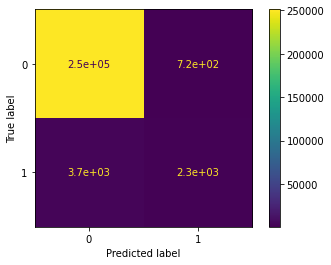

In [20]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(modelo_treinado, X_teste, y_teste)



## **Melhorando a avaliação**
Todas métricas acima foram derivadas do conjunto de teste, que compõe 20% do total de dados. O problema desta técnica é que, como os dados foram separados aleatoriamente, há a possibilidade de que a separação criou conjuntos muito diferentes entre si.

# Bootstrapping
Uma primeira ideia é repetir o proceso todo várias vezes, criando uma separação aleatória a cada vez e treinando modelos independentes. Então, podemos pegar a média das métricas obtidas com cada modelo. Esta técnica de validação cruzada é chamada bootstrapping. Podemos usar a função **ShuffleSplit** do sklearn para isso.

In [21]:
from sklearn.model_selection import ShuffleSplit

X = dados_importantes
y = dados_target

# Vamos criar 10 separações, mantendo 20% de teste em cada uma
rs = ShuffleSplit(n_splits=10, test_size=.2)

# List para armazernamos as acurácias de cada modelo
acuracias = []

# Agora iteramos por cada separação e treinamos um modelo
# O método split retorna índices para o vetor passado como parametro
# O .loc é a maneira de indexar tabelas no pandas a partir de índices
for train_index, test_index in rs.split(X):
  modelo_treinado = modelo.fit(X.loc[train_index], y.loc[train_index])
  predicoes = modelo_treinado.predict(X.loc[test_index])
  acuracias.append(accuracy_score(y.loc[test_index], predicoes))

print(acuracias)
print("Média das acurácias: ", sum(acuracias) / len(acuracias))
#Uma abordagem seria estratificar a separação entre treino/teste. A estratificação procura garantir que a distribuição dos dados é semelhante entre os grupos. Ela pode ser feita tanto para atributos como para rótulos. 


[0.9788001629264698, 0.9778497585196967, 0.977073918187637, 0.9774618383536668, 0.97932385515061, 0.978063114611013, 0.9781600946525205, 0.976996334154431, 0.9777333824698877, 0.9774424423453654]
Média das acurácias:  0.9778904901371298


## K-Fold

Uma alternativa a esta abordagem é denominada validação cruzada *k-fold* (k-partições? Não há uma boa tradução ainda.). A ideia é embaralhar os dados e então dividí-los em *k* partições. Então, separamos a primeira partição como teste e treinamos um modelo nas *k-1* partições restantes; na sequência, separamos a *segunda* partição como teste e treinamos outro modelo nas restantes e assim por diante até que todas partições tenham participado do teste. 

Com isso, treinamos *k* modelos sobre dados diferentes. Como antes, podemos pegar as médias de cada métrica para usarmos como estimativas.

O sklearn nos fornece uma função que automatiza o processo e não precisamos criar o loop manualmente como fizemos antes. Esta função é a `cross_val_score`.

In [22]:
from sklearn.model_selection import cross_val_score

# O parâmetro cv indica quantas partições criaremos
scores = cross_val_score(modelo, X, y, cv=10)
print("Acurácia média: ", scores.mean())

Acurácia média:  0.9774114065415953
